# Unsupervised Learning - An introduction

Unsupervised learning is a type of machine learning where the algorithm learns patterns from unlabelled data. The goal of unsupervised learning is to discover hidden structures or patterns in the data. Techniques like clustering and dimensionality reduction are strongly related and user in unsupervised learning.

While dimension reduction aims to make high-dimensional data manageable, clustering seeks to find the boundary for differentiation within the data. Common dimension reduction techniques are principal component analysis (PCA), based on linear transformation. The goal is to find the desired number of components by the eigenvectors of the covariance matrix of the data.
Other methods include Uniform Manifold Approximation and Projection (UMAP) or t-distributed stochastic neighbor embedding (tSNE). Dimensionality reduction is often used in machine learning to visualize high dimensional features.

Clustering on the other hand tries to optimize a number of cluster centroids on the data to describe it as groups. Clustering can be used to find shared characteristics in features or classify the data into classes (or groups). There is a number of different types of clustering methods. Connectivity models, centroid models, distribution models or density models. Well known clustering methods are KMeans, DBSCAN or MeanShift.

## On autoencoders

The basic goal of the autoencoder is to find an accurate low dimensional representation of the input $x_{i}$, be learning to encode $g_{\phi}$ and decode $f_{\phi}$ the input to latent space (latent code) and reverse decode this latent representation back to the input. The training goal is to obtain good reconstructions from the original input. If that's the case the encoder ($g_{\phi}$) can compress the input feature, while the decoder ($f_{\phi}$) can reconstruct the input ($x'$). After training the encoder can be used to find good low dimensional representations from the input space, for classification or other tasks. Whereas the decoder can be used to generate outputs from low dimensional inputs (a fundamental concept to Generative Adverserial Networks (GANs)).


![Simple autoencoder overview diagram](figures/SimpleAutoEncoder.png)

As the image above suggestes the first network we want to observe is a simple 1-layer autoencoder. It works with a linear layer on the en- and decoding side. This is not a requirement, there are many other autoencoder architectures in the literature. Other known Autencoder layers are Convolutional or Long-Short-Term-Memory (LSTM) layers.

In [1]:
from autoencoders.data import MNISTDataModule
from autoencoders.models.simple import SimpleEncoder, SimpleDecoder, SimpleBlottleneck
from autoencoders.lightning_extension import AutoEncoder
from autoencoders.scripts import run

In [2]:
batch_size = 32
training_size = None
datamodule = MNISTDataModule("./dataset/", batch_size, training_size)
datamodule.prepare_data()
datamodule.setup(stage="fit")

In [3]:
image, label = datamodule.mnist_train[0]
print(image)
print(image.shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 32, 32])


In [4]:
input_shape = (1, 32, 32)
latent_dim = 24
lr = 0.01
encoder = SimpleEncoder(input_shape, latent_dim)
decoder = SimpleDecoder(latent_dim, input_shape)
bottleneck = SimpleBlottleneck(latent_dim)
model = AutoEncoder(encoder, bottleneck, decoder, lr=lr, noise_ratio=None, recon_loss="rmse", prevent_tb_logging=True)
print(model)

AutoEncoder(
  (encoder): SimpleEncoder(
    (layer): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1024, out_features=24, bias=True)
      (2): ReLU()
    )
  )
  (bottleneck): SimpleBlottleneck()
  (decoder): SimpleDecoder(
    (layer): Sequential(
      (0): Linear(in_features=24, out_features=1024, bias=True)
      (1): Sigmoid()
    )
  )
  (criterion_recon): MSELoss()
)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params
------------------------------------------------------
0 | encoder         | SimpleEncoder     | 24.6 K
1 | bottleneck      | SimpleBlottleneck | 0     
2 | decoder         | SimpleDecoder     | 25.6 K
3 | criterion_recon | MSELoss           | 0     
------------------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val/reconstructions at 0


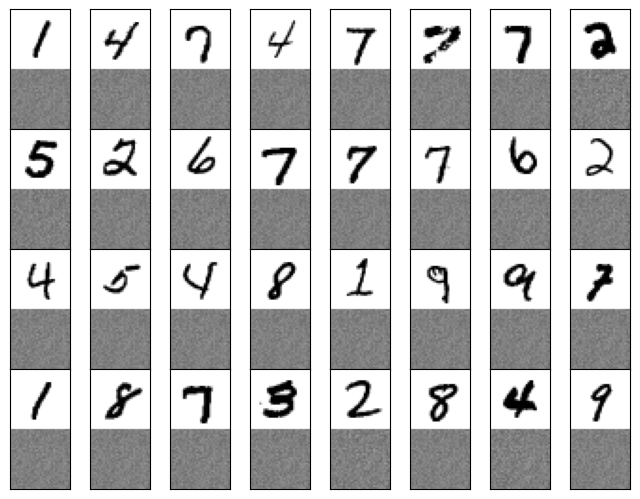

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val/reconstructions at 1719


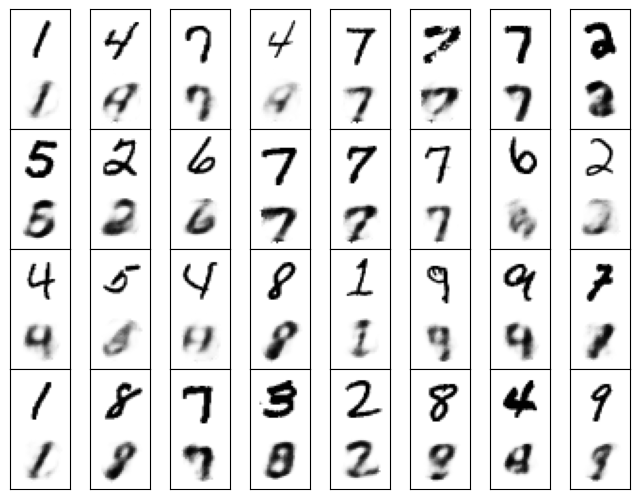

Validation: 0it [00:00, ?it/s]

val/reconstructions at 3438


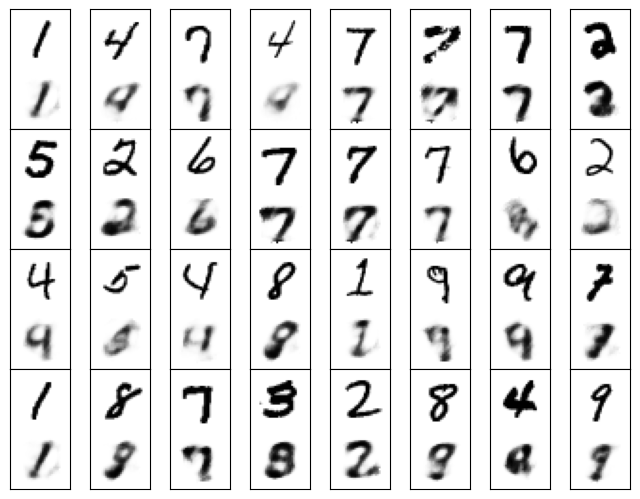

Validation: 0it [00:00, ?it/s]

val/reconstructions at 5157


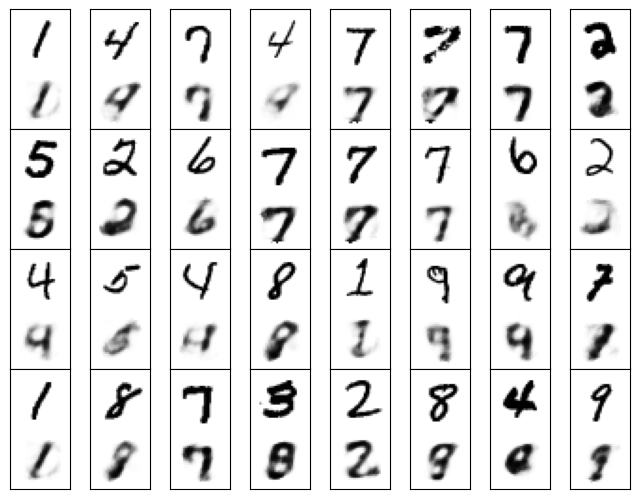

Validation: 0it [00:00, ?it/s]

val/reconstructions at 6876


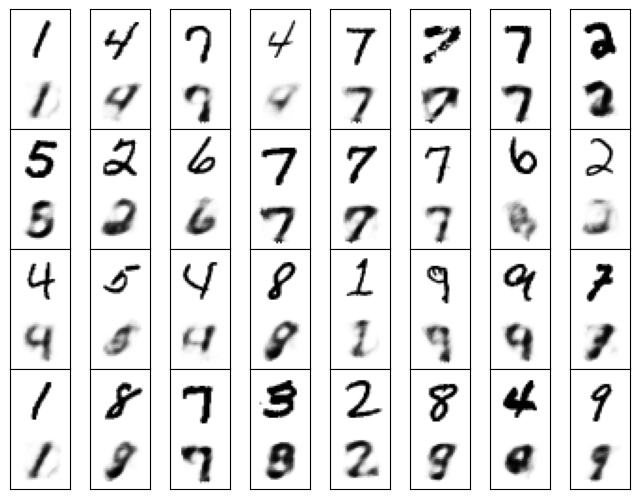

Validation: 0it [00:00, ?it/s]

val/reconstructions at 8595


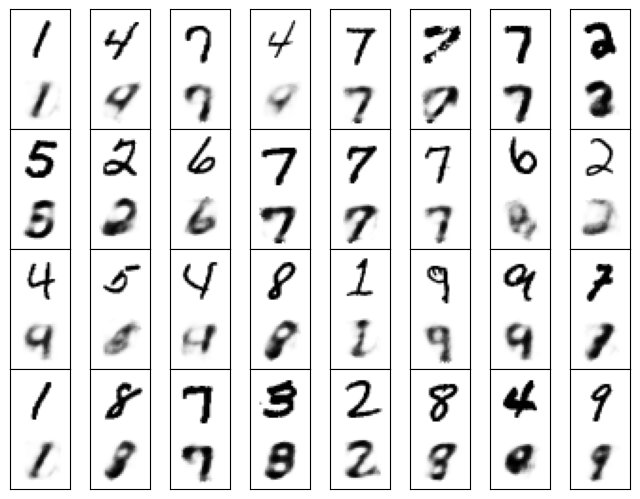

Validation: 0it [00:00, ?it/s]

val/reconstructions at 10314


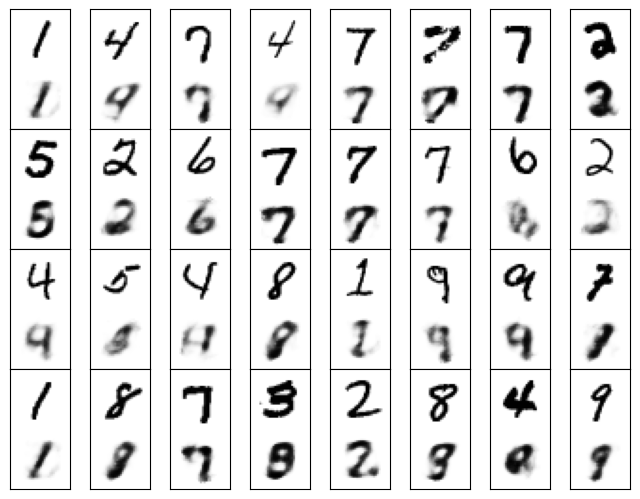

Validation: 0it [00:00, ?it/s]

val/reconstructions at 12033


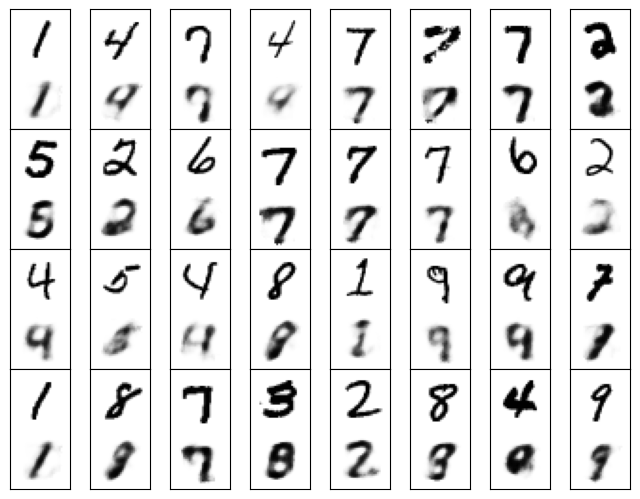

Validation: 0it [00:00, ?it/s]

val/reconstructions at 13752


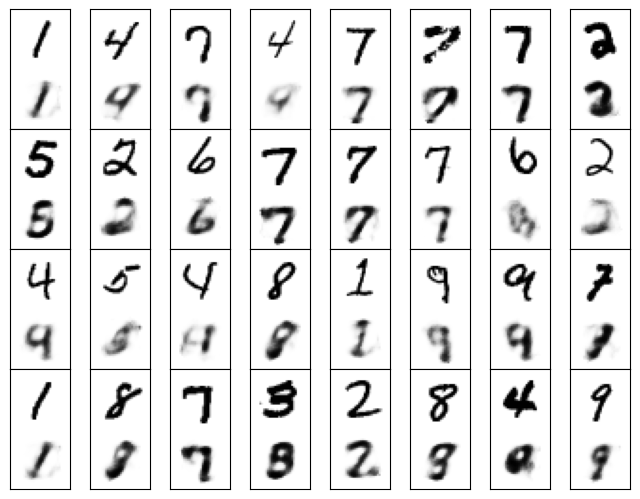

Validation: 0it [00:00, ?it/s]

val/reconstructions at 15471


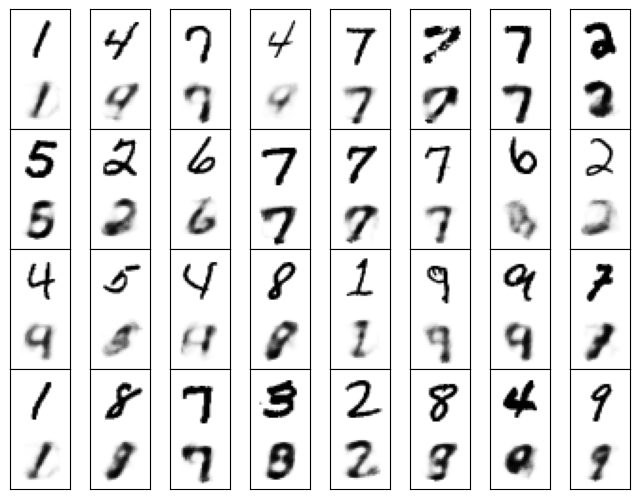

Validation: 0it [00:00, ?it/s]

val/reconstructions at 17190


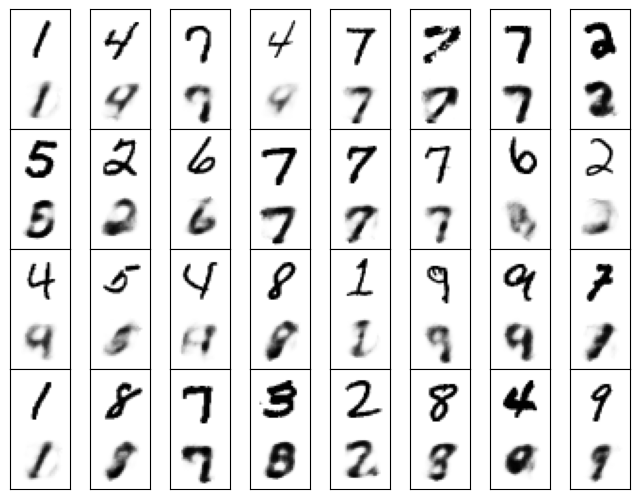

`Trainer.fit` stopped: `max_epochs=10` reached.


''

In [5]:
# We need some jupyter magic to plot inline
%matplotlib inline

# Increase the number of epochs for more accurate results
# Note that the model will most likely converge around 20-35 epochs.
epochs = 5
logger = run.build_logger("simpleautoencoder", datamodule_name="MNIST", task="reconstruction")
run._train(model, logger, datamodule, epochs)